In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import cirpy
from urllib.request import urlopen
from urllib.parse import quote
import pubchempy as pcp
from matplotlib import colors

In [2]:
octane = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\cleaned_octane_database.csv')
comb_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\comb_heat.csv')
boil_p = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\boiling_point.csv')
densit = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\density.csv')
entr_h = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\raw_data\entropy_heat_capacity.csv')
auto_t = pd.read_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\autoignition_temp.csv')

comb_h = comb_h.rename(columns={'Smiles':'SMILES'})
boil_p = boil_p.rename(columns={'Smiles':'SMILES'})
densit = densit.rename(columns={'Smiles':'SMILES'})

print(densit.shape)

(543, 4)


### Find the number of missing physical properties data between octane database and 
####

In [3]:
for df,name in zip([comb_h,boil_p,densit,entr_h,auto_t],['combustion heat','boiling point','density','entropy','autoig. temp']):
    print('Number of missing values for ' + name +' = {}'.format(pd.merge(octane,df,how='left',on='SMILES').iloc[:,-1].isnull().sum()))


Number of missing values for combustion heat = 443
Number of missing values for boiling point = 443
Number of missing values for density = 509
Number of missing values for entropy = 403
Number of missing values for autoig. temp = 396


In [4]:
len(set(octane['SMILES'].values)-set(comb_h['SMILES'].values))

443

# Complexity and XLogP

In [5]:
def X_LogP_Complexity(row):
    smi  = row['SMILES']
    prop = pcp.get_properties(['Complexity', 'XLogP'], smi, 'smiles', as_dataframe=False)[0]
    return prop['Complexity'],prop['XLogP']

In [58]:
octane[['Complexity','XLogP']] = octane.apply(X_LogP_Complexity, axis=1, result_type="expand")

In [59]:
#save results 

octane.to_csv(r'C:\Users\zcemg08\PycharmProjects\biofuels\cleaned_data\cleaned_octane_database.csv')

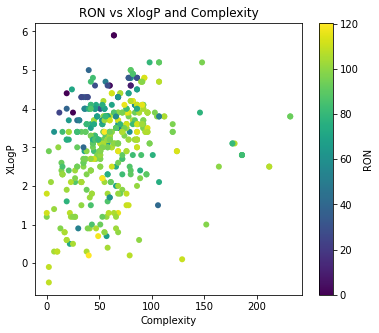

In [86]:
plt.scatter(octane['Complexity'],octane['XLogP'],edgecolors='none',c=octane['y'])
plt.xlabel('Complexity')
plt.ylabel('XLogP') 
plt.title('RON vs XlogP and Complexity')
plt.colorbar(label='RON')
plt.show()

# Boiling Point and Density

###  Knovel Data for boiling point and density 

https://app.knovel.com/web/view/itable/show.v/rcid:kpYHTPPCC4/cid:kt002UT9Q2/viewerType:itble//root_slug:Physical-Properties-and-Refractive-Index/url_slug:physical-properties-refractive?b-q=Yaws%27%20Handbook%20of%20Thermodynamic%20and%20Physical%20Properties%20of%20Chemical%20Compounds&include_synonyms=no&q=Yaws%27%20Handbook%20of%20Thermodynamic%20and%20Physical%20Properties%20of%20Chemical%20Compounds&sort_on=default&start=4950&columns=1,3,4,5,6,8,10,12,13


In [5]:
files_dir    = glob.glob(r"C:\Users\zcemg08\Desktop\bp_density\*.csv")
column_names = ['material','CAS Registry No.','mol. formula','mol. weight','freezing point (K)','boiling point (K)','density (g/cm3)','refractive index temp.','T (Â°C)','refractive index @ T', 'nD'
]

In [6]:
def to_float(x):
    if x=='""' or x =='':
        return None
    else:
        return float(x[1:-1])

    
def string_float(x,idx):
    if idx ==1:
        return str(x[1:-1])
    else:
        return to_float(x)
    return df


def bracket(str_):
    if '(' in str_:
        name = str_.split('(')[0]
        return name
    else:
        return str_


def clean_df(link_,header,skiprows,col):
    
    df     = pd.read_csv(link_,skiprows=skiprows,header=None,sep='delimiter')
    df.drop(df.tail(3).index,inplace=True)
    
    def func_row(row):
        vals_    = row.values[0].split(';')[:len(col)]
        return [string_float(x,idx) for x,idx in zip(vals_,col)]
    
    df[header] = df.apply(func_row,axis=1,result_type='expand')
    
    df = df.drop(0,axis=1)
    
    return df 

def cas_to_smiles(x):
    try:
        query = cirpy.resolve(x, 'smiles')
        if query is None:
            return None
        else:
            return query
    except:
        return None
    
    
def CIRconvert(ids):
    try:
        url = 'http://cactus.nci.nih.gov/chemical/structure/' + quote(ids) + '/smiles'
        ans = urlopen(url).read().decode('utf8')
        return ans
    except:
        return None
    
    
def name_to_smiles(name):
    try:
        smiles = pcp.get_compounds(name, 'name')[0].canonical_smiles
        return smiles
    except:
        return None

In [59]:
#concat and clean all excel pages
data_knovel = pd.concat([clean_df(x) for x in files_dir])

### Fill Smiles column by (1),(2) and (3)
# 1- CAS number to SMILES
# name to smiles by cactus.nci.nih.gov
# name to smiles by pubchem

data_knovel['SMILES']                                    = data_knovel['CAS Registry No.'].apply(cas_to_smiles)
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['material'].apply(CIRconvert)
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['material'].apply(name_to_smiles)

In [60]:
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['SMILES'].apply(CIRconvert)

In [74]:
data_knovel.loc[data_knovel['SMILES'].isnull(),'SMILES'] = data_knovel[data_knovel['SMILES'].isnull()]['SMILES'].apply(CIRconvert)

In [75]:
len(data_knovel[data_knovel['SMILES'].isnull()])/len(data_knovel)

0.23649834275687268

In [76]:
data_knovel.to_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')

### Load processed data for boiling point and density 

In [93]:
bp_den_knovel = pd.read_csv(r'C:\Users\zcemg08\Desktop\data\bp_density_knovel.csv')

In [17]:
bp_den_knovel.head(3)

,Unnamed: 0,material,CAS Registry No.,mol. formula,mol. weight,freezing point (K),boiling point (K),density (g/cm3),refractive index temp.,T (Â°C),SMILES
0,0,abietic acid,514-10-3,C20H30O2,302.457,446.65,649.70,NaN,NaN,NaN,CC(C)C1=CC2=CC[C@@H]3[C@](C)(CCC[C@@]3(C)C(O)=...
1,1,acenaphthene,83-32-9,C12H10,154.211,366.56,550.54,NaN,19.85,1.6420,C1Cc2cccc3cccc1c23
2,2,acetal,105-57-7,C6H14O2,118.176,173.15,376.75,0.821,25.00,1.3682,CCOC(C)OCC


In [19]:
new_df = pd.merge(octane,bp_den_knovel[['SMILES','boiling point (K)','density (g/cm3)']],how='left',on='SMILES')

In [22]:
df2 = new_df[new_df['boiling point (K)'].isnull()]

In [89]:
df3 = pd.merge(df2,boil_p[['SMILES','Boiling_point_K']],how='left',on='SMILES')

In [96]:
df3[df3['Boiling_point_K'].isnull()].head(5)

,Unnamed: 0,SMILES,Compound Name,TARGET,PubChem,Source,Literature Source,RON_Molecules_x,Experiment,Data Set,...,Zagreb1,Zagreb2,mZagreb1,mZagreb2,dev,y,ron_choice,boiling point (K),density (g/cm3),Boiling_point_K
1,5,CC1(C2CCC(O1)(CC2)C)C,"1,3,3-Trimethyl-2-oxabicyclo[2,2,2]octane",99.2,2758,Sandia,NaN,NaN,NaN,NaN,...,64.0,76.0,4.486111,2.166667,NaN,99.2,no alternative,NaN,NaN,NaN
2,10,C1C=CC2C1C3CC2C=C3,dicyclopentadiene,100.8,6492,UML,[1],NaN,NaN,NaN,...,60.0,75.0,1.944444,2.083333,NaN,100.8,no alternative,NaN,NaN,NaN
3,15,CCC(=O)C,2-Butanone,105.3,6569,"Sandia, UML",[9],NaN,NaN,NaN,...,16.0,14.0,3.361111,1.333333,0.0,105.3,abs dev < 0.01,NaN,NaN,NaN
4,17,CC1=CC[C@@H]2C[C@H]1C2(C)C,"2, 6, 6- trimethyl- , (1R, 5R) -bicyclo[3.1.1]...",80.0,6654,"Sandia, UML",[1],NaN,NaN,NaN,...,58.0,72.0,4.145833,2.027778,NaN,80.0,no alternative,NaN,NaN,NaN
5,18,C1C=CC2=CC=CC=C21,indene,102.3,7219,Sandia,NaN,NaN,NaN,NaN,...,46.0,53.0,1.972222,2.027778,NaN,102.3,no alternative,NaN,NaN,NaN


# Autoiginition Temperature 

### 1st folder

https://app.knovel.com/web/view/itable/show.v/rcid:kpRTCEAMQ7/cid:kt008KALU2/viewerType:itble//root_slug:Table-1-Compilation-of-AIT-autoignition-temperature-Data/url_slug:table-1-compilation-ait?b-content-type=igraph%2Citable&b-q=autoignition%20temperature&include_synonyms=no&q=autoignition%20temperature&sort_on=default&start=400&columns=1,2,3,4,5,6&sort=6&direction=DESC

In [10]:
files_auto1    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\*.csv")[1:]

header   = ['compound','lowest_rep_auto_temp_C','lowest_rep_auto_temp_F',\
          'lowest_rep_auto_temp_C_other','lowest_rep_auto_temp_F_other','reference']

col      = [1,0,0,0,0,1]

skiprows = [0,1,2,3,4,5,6,7,8,9,10]


data_auto1 = pd.concat([clean_df(x,header,skiprows,col) for x in files_auto1])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:26: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [11]:
data_auto1.head(3)

,compound,lowest_rep_auto_temp_C,lowest_rep_auto_temp_F,lowest_rep_auto_temp_C_other,lowest_rep_auto_temp_F_other,reference
0,Methane,NaN,NaN,537.0,999.0,17
1,Ethane,515.0,959.0,472.0,882.0,"2, 24"
2,Butane,372.0,702.0,450.0,842.0,"14, 20"


In [35]:
### Find SMILES column 

data_auto1['SMILES']                                   = data_auto1.iloc[:,0].apply(lambda x: name_to_smiles(bracket(x)))
data_auto1.reset_index(inplace=True)
data_auto1.loc[data_auto1['SMILES'].isnull(),'SMILES']  = data_auto1.loc[data_auto1['SMILES'].isnull(),'compound'].apply(\
                                                            lambda x: CIRconvert(bracket(x)))

In [36]:
len(data_auto1.iloc[(data_auto1['SMILES'].isnull()).index,0])

413

In [40]:
len(data_auto1[data_auto1['SMILES'].isnull()])/len(data_auto1)

0.15254237288135594

In [41]:
data_auto1.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_1\auto_combine1.csv')

### 2nd folder 

https://app.knovel.com/web/view/itable/show.v/rcid:kpYCPDCECD/cid:kt009ZN4C9/viewerType:itble//root_slug:Table-110-Autoignition-Temperature---Organic-Compounds/url_slug:table-110-autoignition?b-content-type=igraph%2Citable&b-q=autoignition%20temperature&include_synonyms=no&q=autoignition%20temperature&sort_on=default&start=750&columns=1,2,5,3,4,6,7,8,9

In [79]:
files_auto2    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_2\*.csv")[1:]

header   = ['formular','compound','synonyms','CAS Registry No.',\
             'mol_weight','auto_temp_K','auto_temp_C','auto_temp_F','code']

col      = [1,1,1,1,0,0,0,0,0]

skiprows = [0,1,2,3,4]


df_auto2 = pd.concat([clean_df(x,header,skiprows,col)for x in files_auto2])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [78]:
df_auto2.head(3)

,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code
0,CHClF2,chlorodifluoromethane,view synonyms,75-45-6,86.468,905.00,631.9,1169.3,1.0
1,CHCl2F,dichlorofluoromethane,view synonyms,75-43-4,102.922,825.37,552.2,1026.0,1.0
2,CHN,hydrogen cyanide,view synonyms,74-90-8,27.026,811.00,537.9,1000.1,1.0


In [21]:
### Find SMILES symbols for each row

df_auto2['SMILES']                                 = df_auto2['CAS Registry No.'].apply(cas_to_smiles)
df_auto2.loc[df_auto2['SMILES'].isnull(),'SMILES'] = df_auto2.loc[df_auto2['SMILES'].isnull(),'compound'].apply(name_to_smiles)
df_auto2.loc[df_auto2['SMILES'].isnull(),'SMILES'] = df_auto2.loc[df_auto2['SMILES'].isnull(),'compound'].apply(CIRconvert)

In [27]:
## Print missing SMILES rows 

df_auto2.loc[df_auto2['SMILES'].isnull()] 

,formular,compound,synonyms,CAS Registry No.,mol_weight,auto_temp_K,auto_temp_C,auto_temp_F,code,SMILES
29,C6H6N2,cis-dicyano-1-butene,view synonyms,2141-58-4,106.128,649.0,375.9,708.5,2.0,None
30,C6H6N2,trans-dicyano-1-butene,view synonyms,2141-59-5,106.128,649.0,375.9,708.5,2.0,None


In [28]:
# save results 
df_auto2.to_csv(r'C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_2\auto_combine2.csv')

### 3d folder
https://app.knovel.com/web/view/itable/show.v/rcid:kpYHTPPCC4/cid:kt003DPR01/viewerType:itble//root_slug:Explosion-Limits-in-Air-Flash-Point-and-Autoignition-Temperature-New/url_slug:explosion-limits-in-air?b-content-type=igraph%2Citable&b-q=autoignition%20temperature&include_synonyms=no&q=autoignition%20temperature&sort_on=default&start=3400&columns=2,10,1,11,3,4,5,6,7,8,9

In [61]:
files_auto3    = glob.glob(r"C:\Users\zcemg08\Desktop\data\autoignit_temp\autoignition_compilation_3\*.csv")

header   = ['compound','synonyms','formular','CAS Registry No.','lower explosive limit (vol%)','upper explosive limit (vol%)',\
           'explosive_limit_code','flash_point_F','flash_point_code','auto_temp_F','auto_temp_code']

col      = [1,1,1,1,0,0,1,0,1,0,1]

skiprows = [0,1,2,3,4]

df_auto3 = pd.concat([clean_df(x,header,skiprows,col) for x in files_auto3])

C:\Users\zcemg08\Miniconda3\envs\biofuel\lib\site-packages\ipykernel_launcher.py:18: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


In [81]:
df_auto3.head(3)

,compound,synonyms,formular,CAS Registry No.,lower explosive limit (vol%),upper explosive limit (vol%),explosive_limit_code,flash_point_F,flash_point_code,auto_temp_F,auto_temp_code
0,abietic acid,view synonyms,C20H30O2,514-10-3,0.4,2.8,estimate,435.0,estimate,NaN,
1,acenaphthene,view synonyms,C12H10,83-32-9,0.8,6.7,estimate,236.0,estimate,NaN,
2,acetal,view synonyms,C6H14O2,105-57-7,1.6,10.4,experimental,-5.0,experimental,446,experimental


In [62]:
print('Number of compunds with not null autoignition temperature = {}'.format(df_auto3['auto_temp_F'].notnull().sum()))

Number of compunds with not null autoignition temperature = 514
